In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime
from keras.models import Model,Sequential
from keras.layers import  LSTM
from keras.layers.core import Activation, Dropout, Dense
from sklearn.model_selection import train_test_split
from sklearn.linear_model import (LinearRegression,Lasso,Ridge,ElasticNet,HuberRegressor,Lars,LassoLars,
                                  PassiveAggressiveRegressor,RANSACRegressor,SGDRegressor)
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.metrics import  mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import itertools

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


In [3]:
df = pd.read_csv('Equites_Historical_NonAdjusted_Prices.csv', usecols=['Industry Group', 'Symbol', 
                                                                       'Company Name', 'Date', 'Open', 'High',
                                                                       'Low', 'Close', 'Change', '% Change', 
                                                                       'Volume Traded','Value Traded (SAR)', 
                                                                       'No. of Trades'])

In [4]:
df.Date = pd.to_datetime(df.Date, dayfirst=True)

In [5]:
df.sort_values('Date',inplace=True)

In [6]:
df.head(4)

,Industry Group,Symbol,Company Name,Date,Open,High,Low,Close,Change,% Change,Volume Traded,Value Traded (SAR),No. of Trades
138707,Materials,2260,Sahara Petrochemical Co.,2009-01-03,12.15,12.90,12.10,12.85,0.80,6.63,2617351,32610608.60,989
237007,Retailing,4050,Saudi Automotive Services Co.,2009-01-03,11.75,12.15,11.75,12.05,0.50,4.32,2767819,33195157.05,1206
73500,Materials,2020,Saudi Arabian Fertilizer Co.,2009-01-03,92.00,98.50,92.00,98.50,8.75,9.74,871456,84833829.25,999
407889,Insurance,8180,Al Sagr Cooperative Insurance Co.,2009-01-03,12.15,13.25,12.15,13.25,1.15,9.50,2091187,26429787.35,1209


In [7]:
df['Company Name'].groupby(df['Industry Group']).value_counts()

Industry Group  Company Name                           
Banks           Al Rajhi Bank                              2722
                Alinma Bank                                2722
                Arab National Bank                         2722
                Bank Albilad                               2722
                Bank Aljazira                              2722
                                                           ... 
Transportation  Saudi Public Transport Co.                 2722
                United International Transportation Co.    2722
                Saudi Ground Services Co.                  1102
Utilities       National Gas and Industrialization Co.     2722
                Saudi Electricity Co.                      2722
Name: Company Name, Length: 205, dtype: int64

In [8]:
Riyad_Bank = df[df['Company Name']== 'Riyad Bank']

In [9]:
Riyadhb_for_model = Riyad_Bank[['Date','Open', 'High', 'Low',
       'Close', 'Change', '% Change']]

In [10]:
Riyadhb_for_model.head(4)

,Date,Open,High,Low,Close,Change,% Change
2121,2009-01-03,21.00,21.85,21.00,21.75,0.55,2.59
2123,2009-01-04,21.70,21.70,21.30,21.65,-0.10,-0.45
2133,2009-01-05,21.45,21.80,21.45,21.80,0.15,0.69
2118,2009-01-06,21.60,21.85,21.55,21.80,0.00,0.00


In [11]:
Riyadhb_for_model.reset_index(inplace=True)

In [12]:

#Create a data point (i.e. a date) which splits the training and testing set
split_date = list(Riyadhb_for_model["Date"][-(227):])[0]

In [13]:
split_date

Timestamp('2019-01-01 00:00:00')

In [14]:
Riyadh_for_arima = Riyadhb_for_model[['Date', 'Open', 'High', 'Low', 'Close', 'Change', '% Change']]

In [15]:
Riyadh_for_arima.set_index('Date',inplace=True)

In [16]:
training_set, test_set = Riyadhb_for_model[Riyadhb_for_model['Date'] < split_date], Riyadhb_for_model[Riyadhb_for_model['Date'] >= split_date]


In [17]:
training_set.shape

(2495, 8)

In [18]:
test_set.shape

(227, 8)

In [19]:
test_set.set_index('Date',inplace=True)

In [20]:
training_set.set_index('Date',inplace=True)

In [21]:
training_set = training_set.drop(['index'], 1)
test_set = test_set.drop(['index'], 1)

In [22]:
training = training_set.values

In [23]:
testing = test_set.values

## LSTM

## Window length

In [24]:
window_len = 5

LSTM_training_inputs = []
for i in range(len(training)-window_len):
    temp_set = training[i:(i+window_len)].copy()
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = training_set['Close'][window_len:].values
LSTM_training_inputs = np.array(LSTM_training_inputs)


#Create windows for testing
LSTM_test_inputs = []
for i in range(len(testing)-window_len):
    temp_set1 = testing[i:(i+window_len)].copy()
    LSTM_test_inputs.append(temp_set1)
LSTM_test_outputs = test_set['Close'][window_len:].values
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [25]:
LSTM_test_inputs.shape

(222, 5, 6)

In [26]:
LSTM_training_inputs.shape

(2490, 5, 6)

In [27]:
# If you want to reste the model 
# nn_model.reset_states()
# nn_model.reset_metrics()

In [28]:
def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [29]:

nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 400)

nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=120, batch_size=160, verbose=1,validation_split= 0.2)

Train on 1992 samples, validate on 498 samples
Epoch 1/120
1992/1992 [==============================] - 1s 458us/step - loss: 14.3071 - val_loss: 3.9187
Epoch 2/120
1992/1992 [==============================] - 0s 245us/step - loss: 5.9098 - val_loss: 9.4814
Epoch 3/120
1992/1992 [==============================] - 0s 249us/step - loss: 4.6610 - val_loss: 9.5128
Epoch 4/120
1992/1992 [==============================] - 0s 245us/step - loss: 4.2170 - val_loss: 7.7342
Epoch 5/120
1992/1992 [==============================] - 1s 253us/step - loss: 3.4658 - val_loss: 5.3730
Epoch 6/120
1992/1992 [==============================] - 1s 282us/step - loss: 2.3150 - val_loss: 2.1073
Epoch 7/120
1992/1992 [==============================] - 0s 243us/step - loss: 1.2884 - val_loss: 0.3151
Epoch 8/120
1992/1992 [==============================] - 0s 247us/step - loss: 0.8616 - val_loss: 0.2240
Epoch 9/120
1992/1992 [==============================] - 1s 251us/step - loss: 0.7382 - val_loss: 0.2814
Epoch 1

Epoch 78/120
1992/1992 [==============================] - 1s 334us/step - loss: 0.4562 - val_loss: 0.3727
Epoch 79/120
1992/1992 [==============================] - 1s 282us/step - loss: 0.4718 - val_loss: 0.2559
Epoch 80/120
1992/1992 [==============================] - 1s 300us/step - loss: 0.4574 - val_loss: 0.1561
Epoch 81/120
1992/1992 [==============================] - 1s 284us/step - loss: 0.4258 - val_loss: 0.1543
Epoch 82/120
1992/1992 [==============================] - 1s 280us/step - loss: 0.4321 - val_loss: 0.1462
Epoch 83/120
1992/1992 [==============================] - 1s 285us/step - loss: 0.4412 - val_loss: 0.1757
Epoch 84/120
1992/1992 [==============================] - 1s 278us/step - loss: 0.4701 - val_loss: 0.2833
Epoch 85/120
1992/1992 [==============================] - 1s 284us/step - loss: 0.4330 - val_loss: 0.1565
Epoch 86/120
1992/1992 [==============================] - 1s 278us/step - loss: 0.4281 - val_loss: 0.1453
Epoch 87/120
1992/1992 [======================

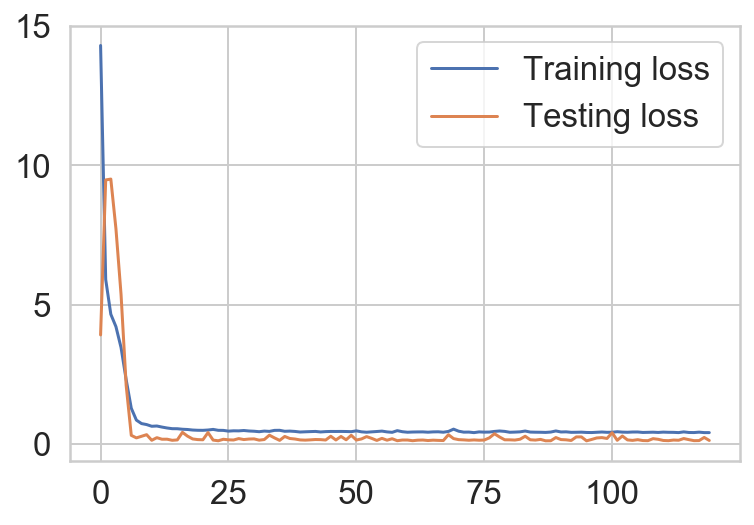

In [30]:
train_loss = nn_history.history['loss']
test_loss = nn_history.history['val_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.legend()

In [31]:
#Reshape from 3D array to 2D array to fit the other models 
X_train = LSTM_training_inputs.reshape((2490,30))
X_test = LSTM_test_inputs.reshape((222,30))

## ARIMA

In [32]:
y = Riyadh_for_arima['Close'].resample('MS').mean()

In [33]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [34]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        except:
            continue
        results = mod.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1172.6582352122564
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:963.2011290721391
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:821.9661222123382
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:777.1725240260143
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:706.1049047347093
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:632.6268839970346
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:770.4042193003661
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:654.9050104639325
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:582.1014659886323
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:782.9857684380507
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:777.7266705608357
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:682.801985291848
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:711.7677871057302
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:707.6336441731903
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:630.8673990025095
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:676.5961235922939
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:656.8384925327624
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:578.4329678502952
ARIMA(0, 0

ARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:398.67569075365225
ARIMA(0, 1, 2)x(1, 2, 0, 12)12 - AIC:507.32913480028503
ARIMA(0, 1, 2)x(1, 2, 1, 12)12 - AIC:448.93691411994007
ARIMA(0, 1, 2)x(1, 2, 2, 12)12 - AIC:392.8877538152024
ARIMA(0, 1, 2)x(2, 0, 0, 12)12 - AIC:439.45848931387485
ARIMA(0, 1, 2)x(2, 0, 1, 12)12 - AIC:441.4069773771229
ARIMA(0, 1, 2)x(2, 0, 2, 12)12 - AIC:433.67477702612047
ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:425.1814008492448
ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:414.4404382917462
ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:400.9887578777683
ARIMA(0, 1, 2)x(2, 2, 0, 12)12 - AIC:430.89738401176356
ARIMA(0, 1, 2)x(2, 2, 1, 12)12 - AIC:409.1324120515891
ARIMA(0, 1, 2)x(2, 2, 2, 12)12 - AIC:396.77458883651656
ARIMA(0, 2, 0)x(0, 0, 0, 12)12 - AIC:591.8196192323464
ARIMA(0, 2, 0)x(0, 0, 1, 12)12 - AIC:529.8217294583959
ARIMA(0, 2, 0)x(0, 0, 2, 12)12 - AIC:486.4305752242805
ARIMA(0, 2, 0)x(0, 1, 0, 12)12 - AIC:617.1553079515786
ARIMA(0, 2, 0)x(0, 1, 1, 12)12 - AIC:499.9215796023634
ARI

ARIMA(1, 0, 2)x(0, 0, 2, 12)12 - AIC:434.7233396482749
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:548.6246898824216
ARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:446.19251298102023
ARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:401.6752940659825
ARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC:608.3494229653256
ARIMA(1, 0, 2)x(0, 2, 1, 12)12 - AIC:472.2225272611902
ARIMA(1, 0, 2)x(0, 2, 2, 12)12 - AIC:396.22989452278887
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:477.17622505882173
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:472.93001651019375
ARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:436.718810328364
ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:476.21470991555685
ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:445.4376679049594
ARIMA(1, 0, 2)x(1, 1, 2, 12)12 - AIC:403.16209127753257
ARIMA(1, 0, 2)x(1, 2, 0, 12)12 - AIC:504.4807852437967
ARIMA(1, 0, 2)x(1, 2, 1, 12)12 - AIC:453.1548983329947
ARIMA(1, 0, 2)x(1, 2, 2, 12)12 - AIC:404.42246698646306
ARIMA(1, 0, 2)x(2, 0, 0, 12)12 - AIC:440.86644163391975
ARIMA(1, 0, 2)x(2, 0, 1, 12)12 - AIC:442.82844305952966
AR

ARIMA(1, 2, 1)x(1, 2, 1, 12)12 - AIC:456.1836424635561
ARIMA(1, 2, 1)x(1, 2, 2, 12)12 - AIC:398.93633307831703
ARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:438.263702937193
ARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:440.24917616763344
ARIMA(1, 2, 1)x(2, 0, 2, 12)12 - AIC:438.34691439647935
ARIMA(1, 2, 1)x(2, 1, 0, 12)12 - AIC:423.1330305167913
ARIMA(1, 2, 1)x(2, 1, 1, 12)12 - AIC:408.14601064315855
ARIMA(1, 2, 1)x(2, 1, 2, 12)12 - AIC:405.5137333247113
ARIMA(1, 2, 1)x(2, 2, 0, 12)12 - AIC:427.2094188374213
ARIMA(1, 2, 1)x(2, 2, 1, 12)12 - AIC:407.3339211942399
ARIMA(1, 2, 1)x(2, 2, 2, 12)12 - AIC:402.66464402980375
ARIMA(1, 2, 2)x(0, 0, 0, 12)12 - AIC:513.7432495189139
ARIMA(1, 2, 2)x(0, 0, 1, 12)12 - AIC:468.1622660974696
ARIMA(1, 2, 2)x(0, 0, 2, 12)12 - AIC:431.6288894243646
ARIMA(1, 2, 2)x(0, 1, 0, 12)12 - AIC:548.51053474263
ARIMA(1, 2, 2)x(0, 1, 1, 12)12 - AIC:446.38639004222324
ARIMA(1, 2, 2)x(0, 1, 2, 12)12 - AIC:399.7259984403816
ARIMA(1, 2, 2)x(0, 2, 0, 12)12 - AIC:610.641185104017
ARIMA(1,

ARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:446.7346688650016
ARIMA(2, 1, 1)x(0, 1, 2, 12)12 - AIC:403.28412585568327
ARIMA(2, 1, 1)x(0, 2, 0, 12)12 - AIC:612.7489849854285
ARIMA(2, 1, 1)x(0, 2, 1, 12)12 - AIC:476.49218141777493
ARIMA(2, 1, 1)x(0, 2, 2, 12)12 - AIC:397.15662698306005
ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:471.37208613396115
ARIMA(2, 1, 1)x(1, 0, 1, 12)12 - AIC:473.3688850268508
ARIMA(2, 1, 1)x(1, 0, 2, 12)12 - AIC:436.9438280438975
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:471.41999492397036
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:447.41047178048495
ARIMA(2, 1, 1)x(1, 1, 2, 12)12 - AIC:404.62366612862695
ARIMA(2, 1, 1)x(1, 2, 0, 12)12 - AIC:500.10227187242856
ARIMA(2, 1, 1)x(1, 2, 1, 12)12 - AIC:454.9130306443075
ARIMA(2, 1, 1)x(1, 2, 2, 12)12 - AIC:399.51403438202794
ARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:434.8727403647558
ARIMA(2, 1, 1)x(2, 0, 1, 12)12 - AIC:436.7805199544103
ARIMA(2, 1, 1)x(2, 0, 2, 12)12 - AIC:438.7079117952586
ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:419.24666248343107


In [43]:
#ARIMA(0, 1, 2)x(0, 2, 2, 12)12 - AIC:390.88788508639425

mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0,1,2),
                                seasonal_order=(0,2,2,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1912      0.155      1.230      0.219      -0.114       0.496
ma.L2         -0.1005      0.191     -0.527      0.598      -0.474       0.273
ma.S.L12      -1.8687      0.373     -5.016      0.000      -2.599      -1.139
ma.S.L24       1.1282      0.378      2.983      0.003       0.387       1.870
sigma2         4.5718      2.010      2.274      0.023       0.632       8.512


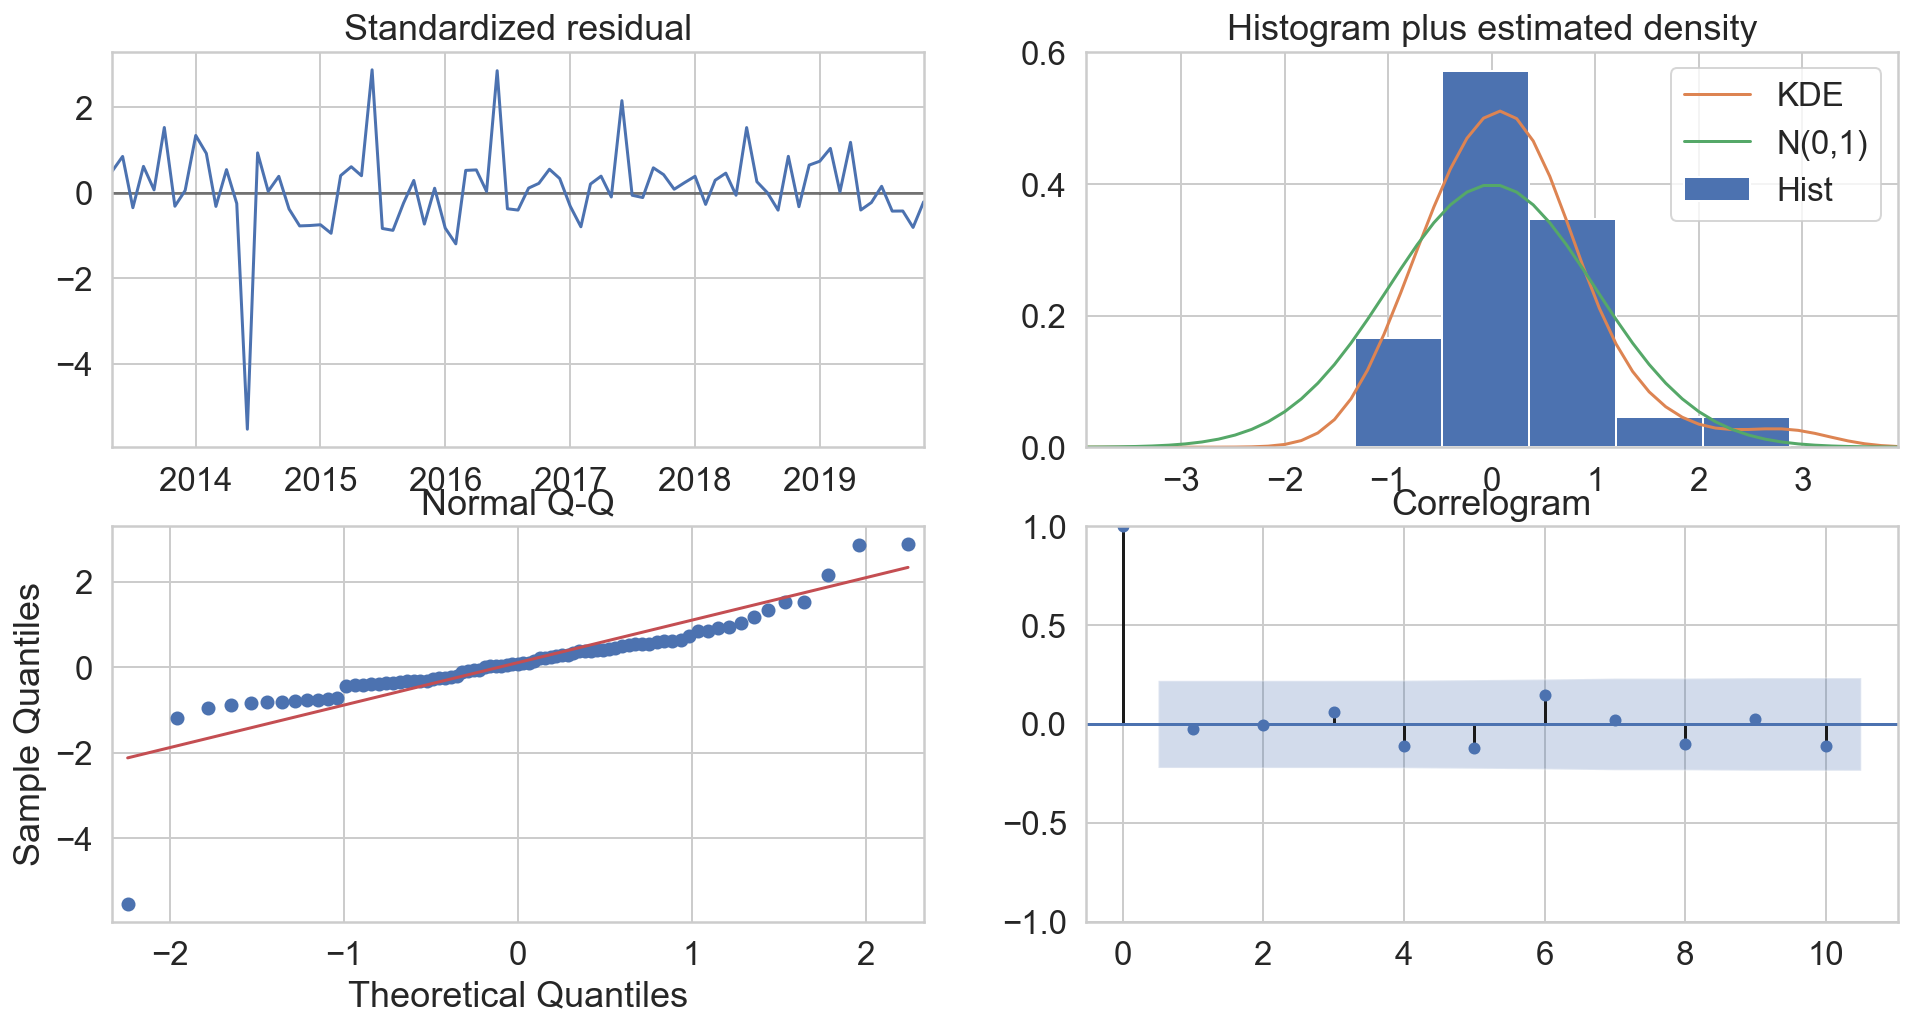

In [44]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Validating forecasts

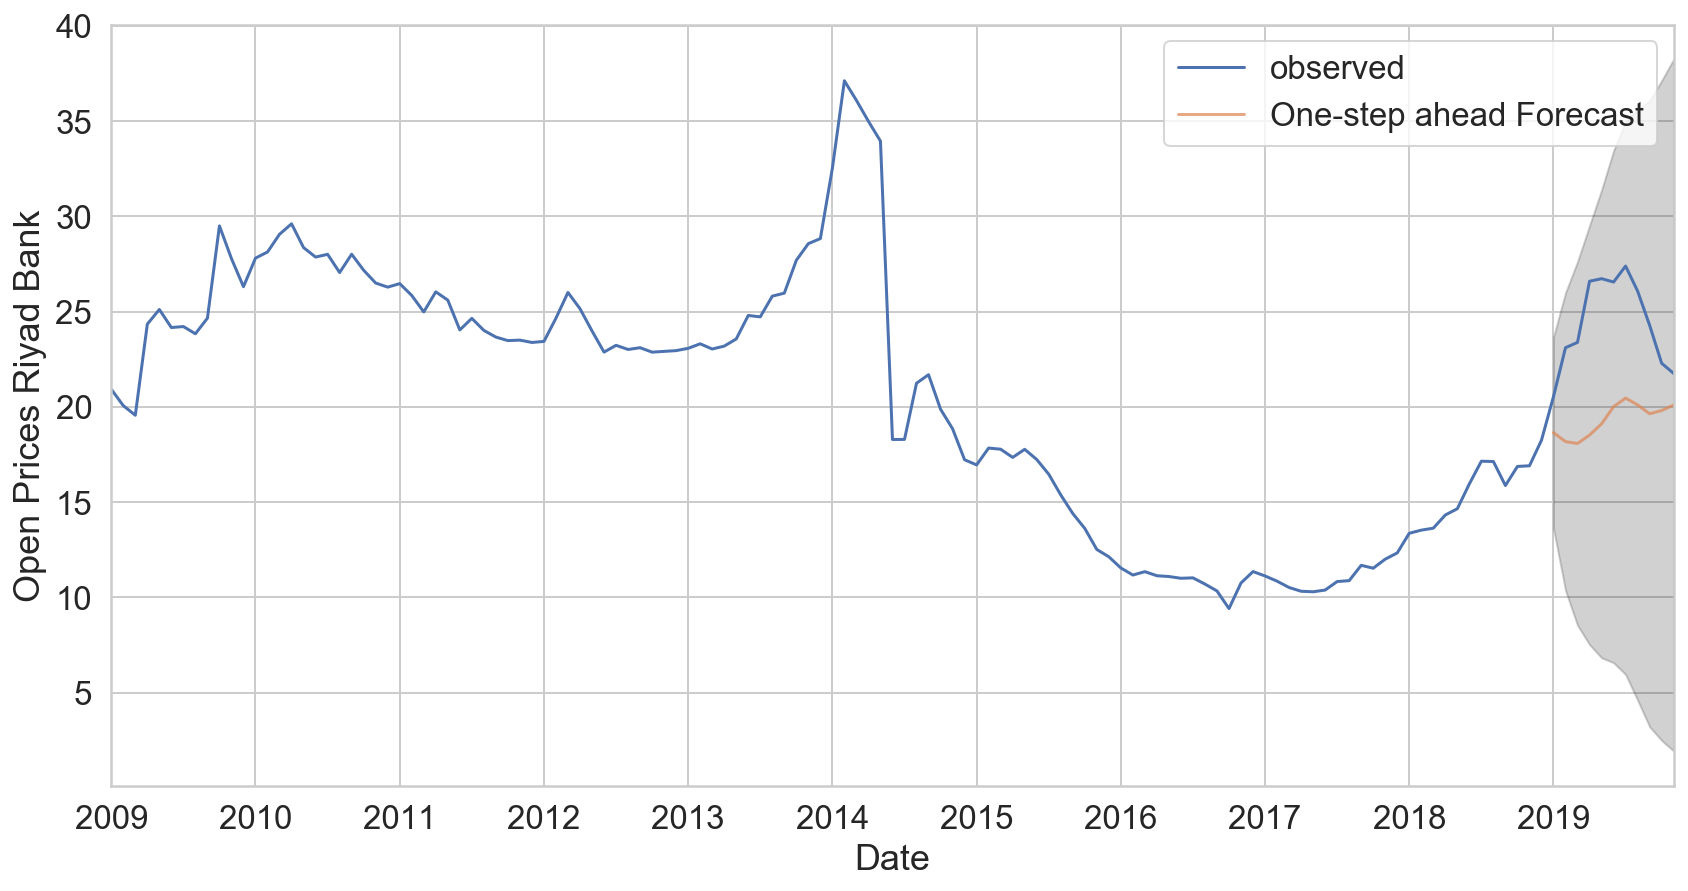

In [46]:
#Here i choose the start of 2019
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=True)
pred_ci = pred.conf_int()
ax = y['2009':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Open Prices Riyad Bank')
plt.legend()
plt.show()

In [47]:
y_forecasted = pred.predicted_mean
y_truth = y['2019-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 30.6


In [48]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 5.53


## Producing and visualizing forecasts

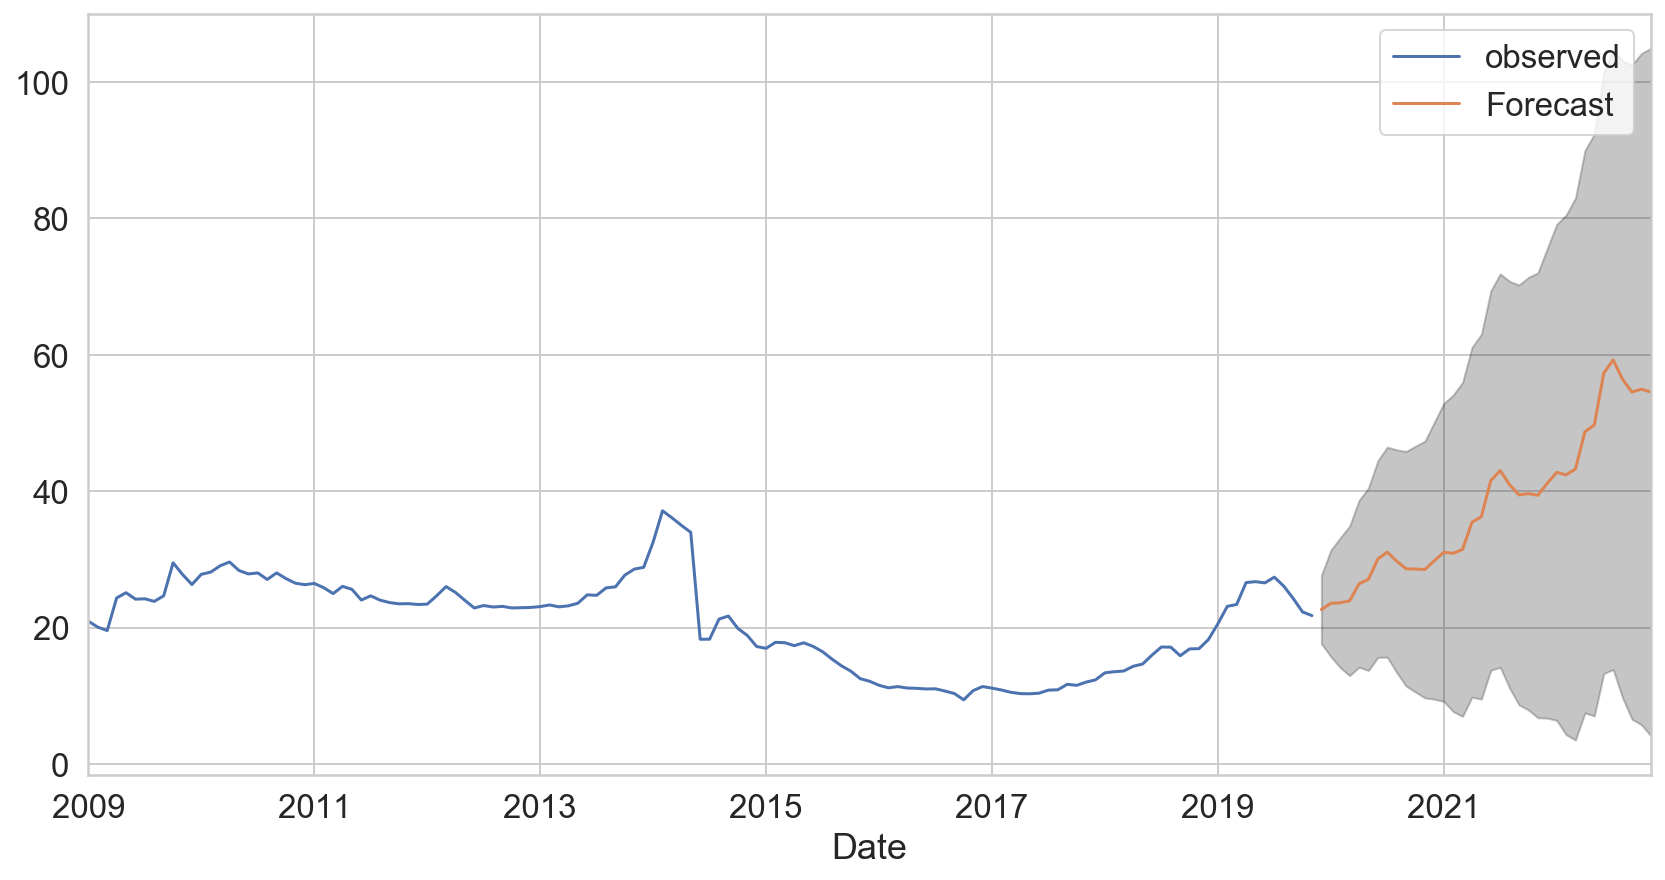

In [50]:
pred_uc = results.get_forecast(steps=36)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
plt.legend()
plt.show()

## Model 

In [52]:
gboost  = GradientBoostingRegressor()
rt      = RandomForestRegressor()
lr      = LinearRegression()
lasso   = Lasso()
ridge   = Ridge()
en      = ElasticNet()
huber   = HuberRegressor()
lars    = Lars()

pa      = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
ranscac = RANSACRegressor()

mod = [lr, lasso, ridge, en, huber, lars, pa, ranscac, gboost, rt,# llars, sgd
      ]

In [53]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    model.predict(X_train)
    model.predict(X_test)


In [57]:
for i in mod:
     evaluate_model(i,X_train, LSTM_training_outputs, X_test, LSTM_test_outputs)

In [58]:
LSTM_pred = nn_model.predict(LSTM_test_inputs).T[0]

In [59]:
Lr_train_pred = lr.predict(X_train)
Lr_test_pred = lr.predict(X_test)
Lasso_train_pred = lasso.predict(X_train)
Lasso_test_pred = lasso.predict(X_test)
Ridge_train_pred = ridge.predict(X_train)
Ridge_test_pred = ridge.predict(X_test)
ElasticNet_train_pred = en.predict(X_train)
ElasticNet_test_pred = en.predict(X_test)
HuberRegressor_train_pred = huber.predict(X_train)
HuberRegressor_test_pred = huber.predict(X_test)
Lars_train_pred = lars.predict(X_train)
Lars_test_pred = lars.predict(X_test)

PassiveAggressiveRegressor_train_pred = pa.predict(X_train)
PassiveAggressiveRegressor_test_pred = pa.predict(X_test)
RANSACRegressor_train_pred = ranscac.predict(X_train)
RANSACRegressor_test_pred = ranscac.predict(X_test)

GradientBoostingRegressor_train_pred = gboost.predict(X_train)
GradientBoostingRegressor_test_pred = gboost.predict(X_test)
RandomForestRegressor_train_pred  = rt.predict(X_train)
RandomForestRegressor_test_pred  = rt.predict(X_test)

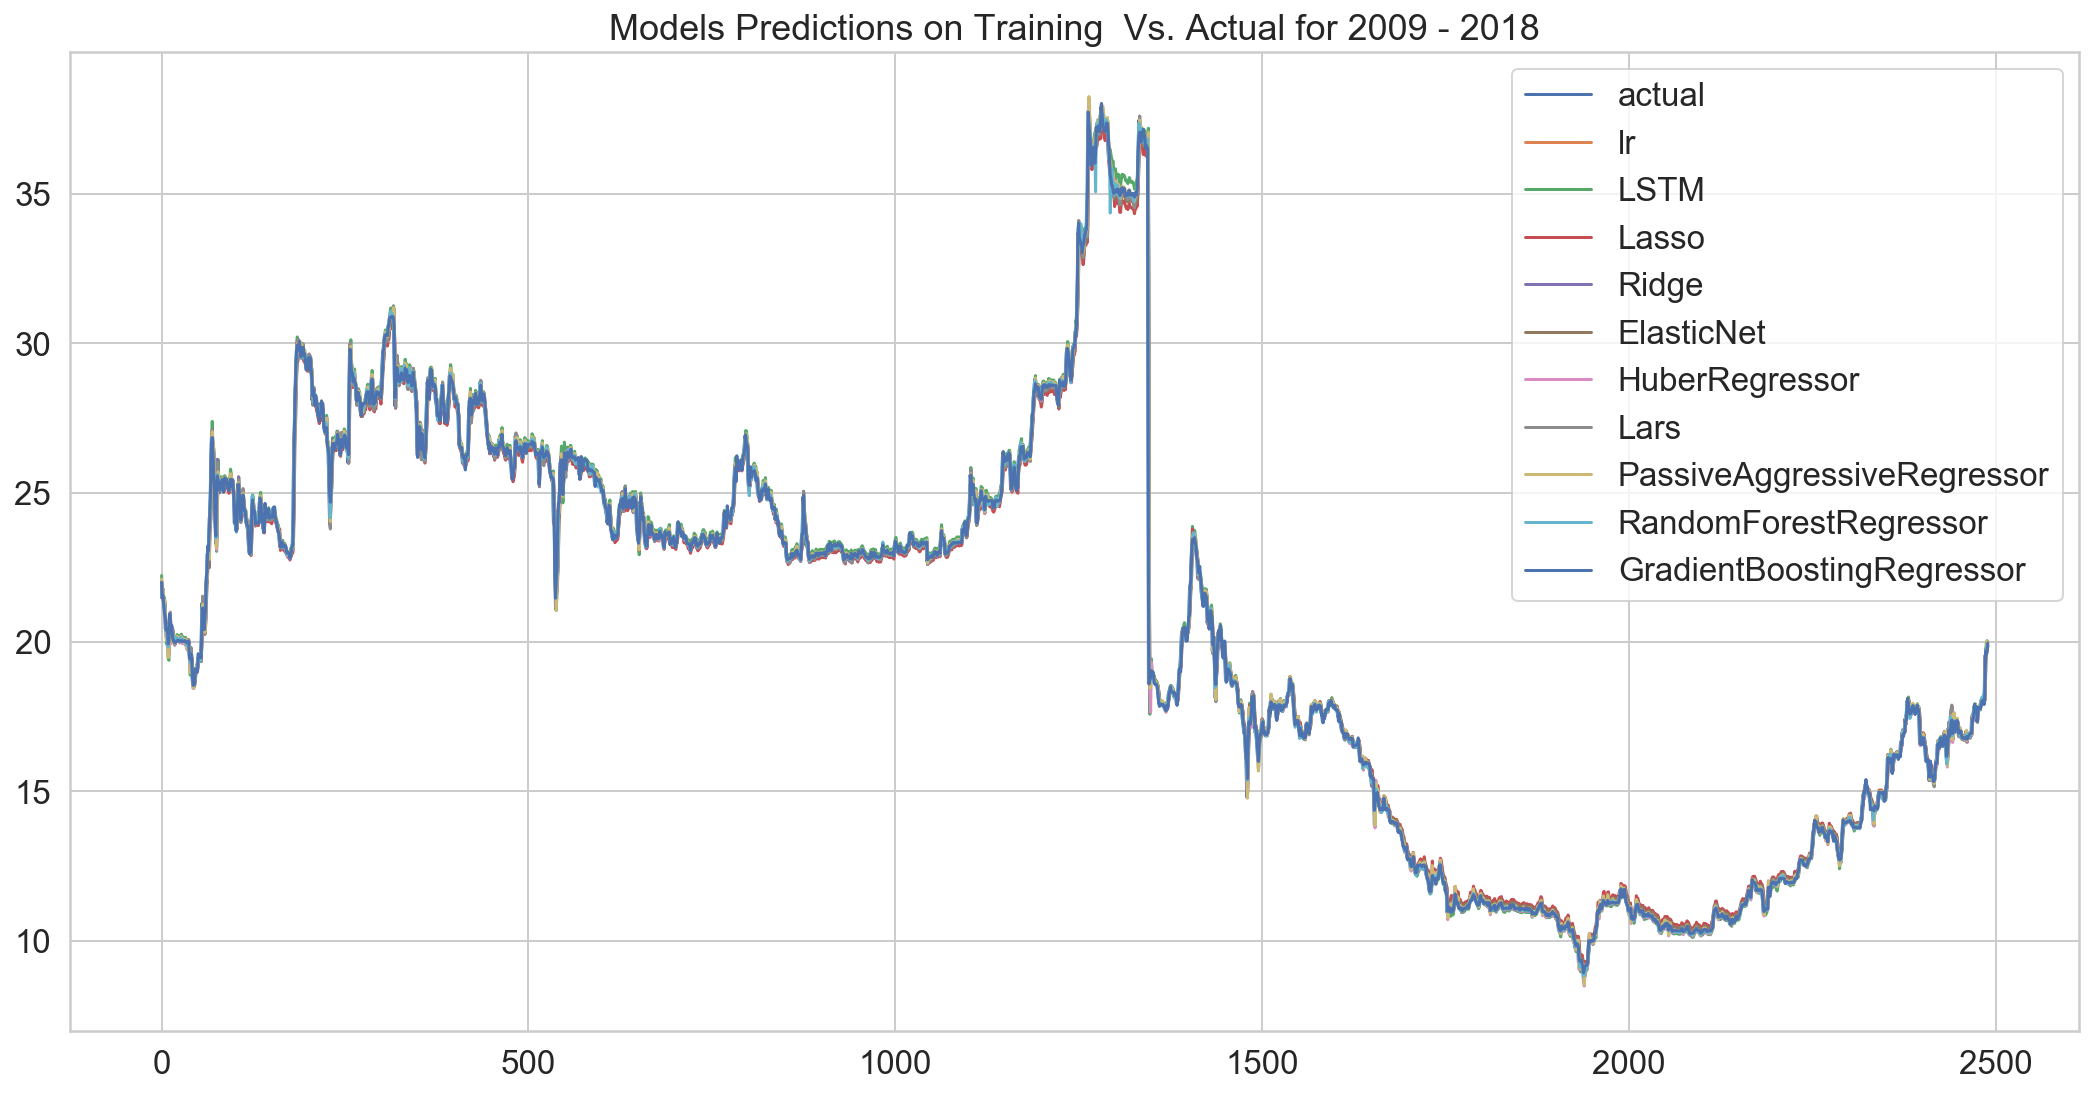

In [60]:
fig = plt.subplots( figsize=(18,9))
plt.plot(LSTM_training_outputs, label = "actual")
plt.plot(Lr_train_pred, label = "lr")
plt.plot(nn_model.predict(LSTM_training_inputs), label = "LSTM")
plt.plot(Lasso_train_pred, label = "Lasso")
plt.plot(Ridge_train_pred, label = "Ridge")
plt.plot(ElasticNet_train_pred, label = "ElasticNet")
plt.plot(HuberRegressor_train_pred, label = "HuberRegressor")
plt.plot(Lars_train_pred, label = "Lars")
# 
plt.plot(PassiveAggressiveRegressor_train_pred, label = "PassiveAggressiveRegressor")
plt.plot(RandomForestRegressor_train_pred, label = "RandomForestRegressor")
plt.plot(GradientBoostingRegressor_train_pred, label = "GradientBoostingRegressor")
# plt.plot(RANSACRegressor_tradin_pred, label = "RANSACRegressor")

plt.title('Models Predictions on Training  Vs. Actual for 2009 - 2018')
plt.legend()
plt.show()

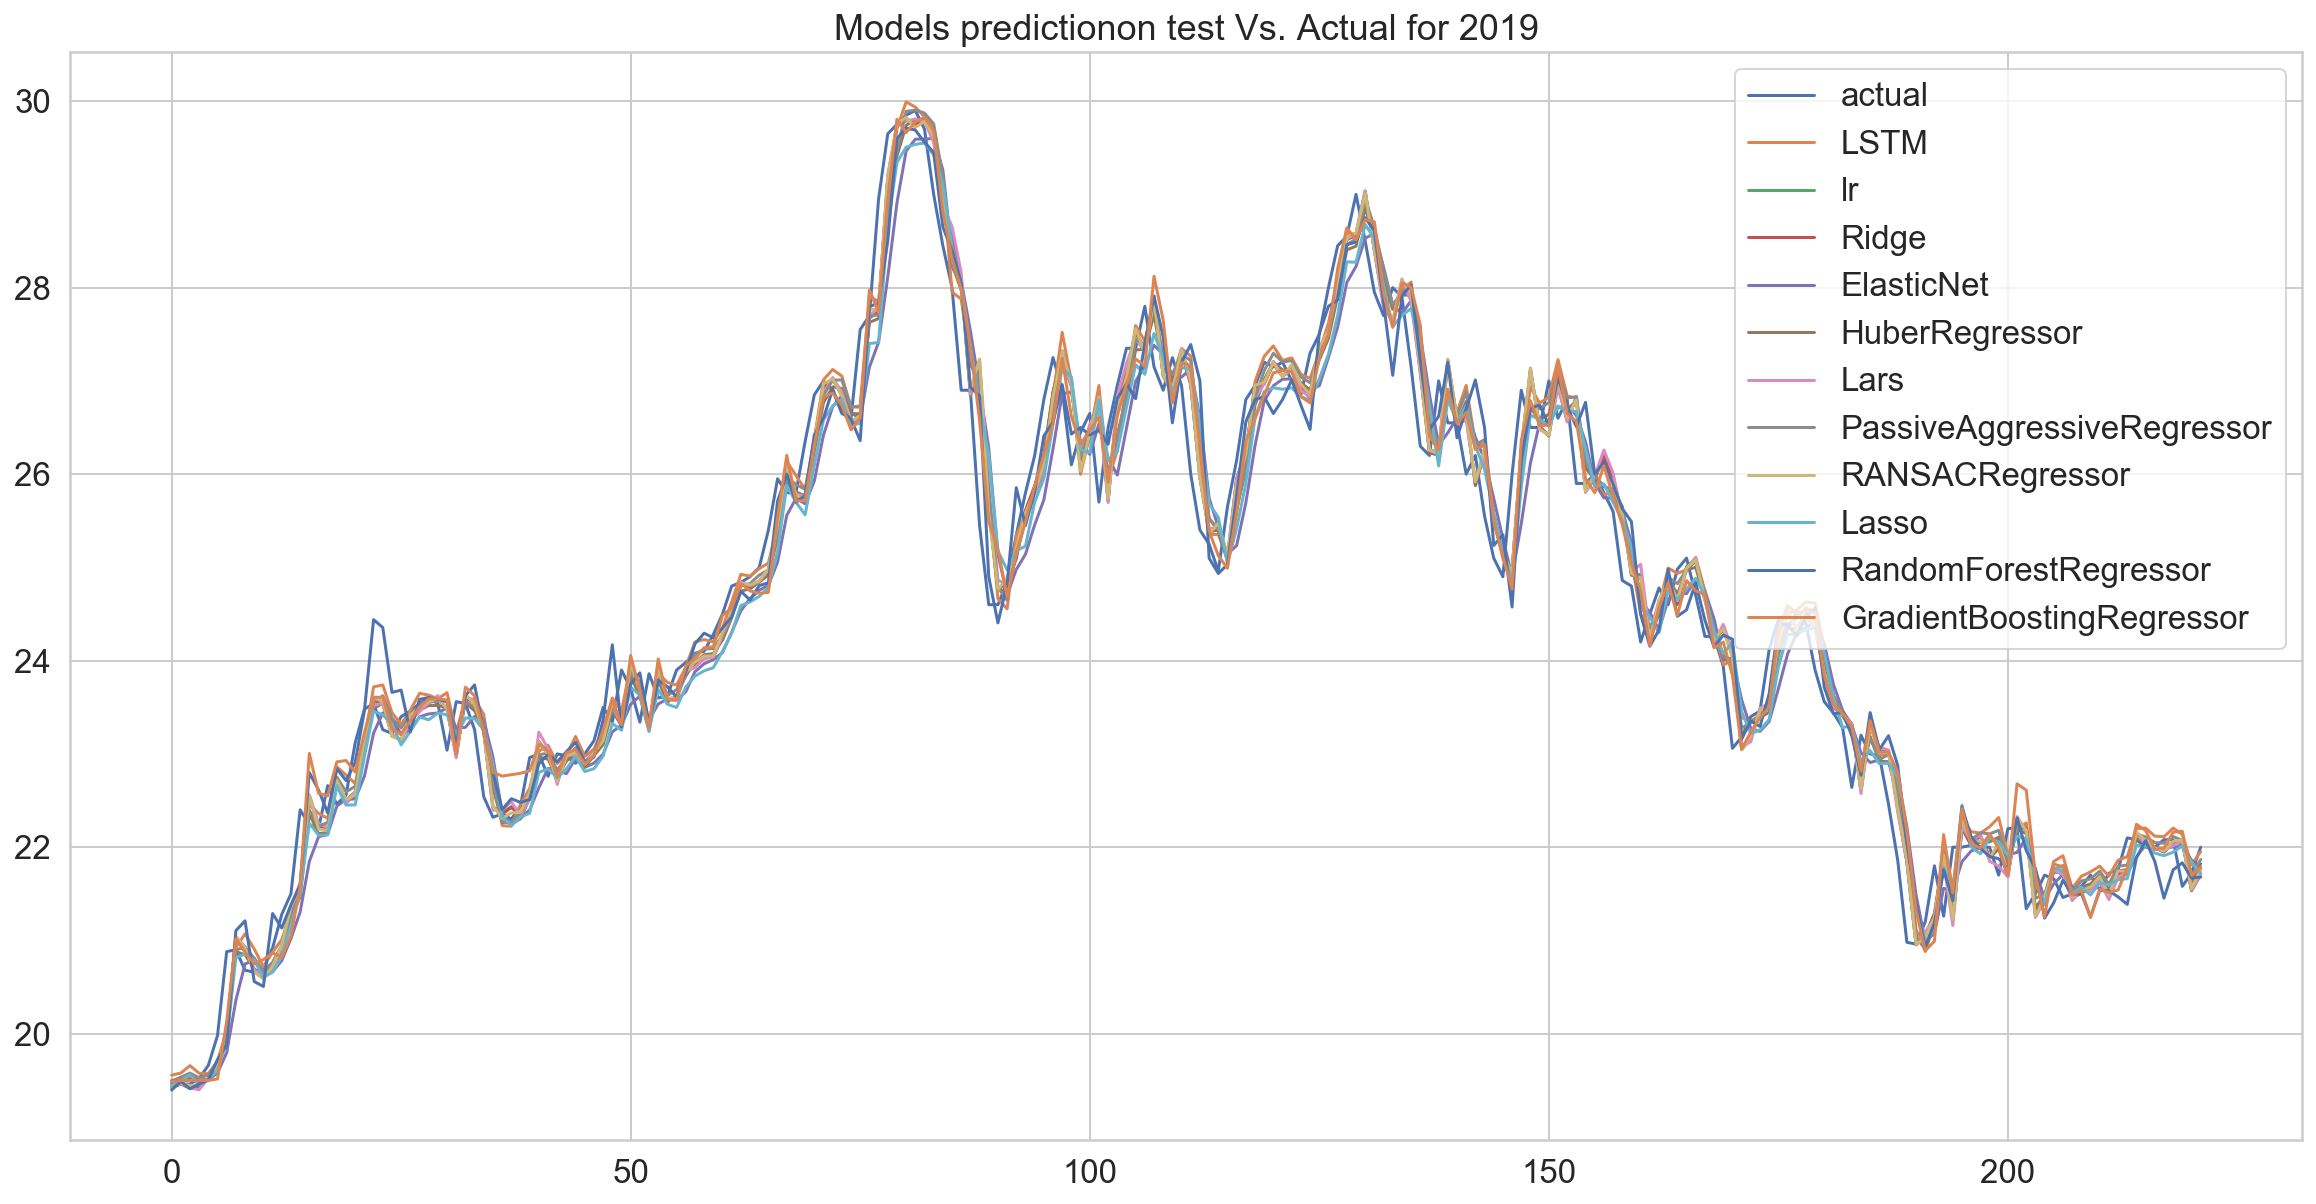

In [61]:
fig = plt.subplots( figsize=(20,10))
plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "LSTM")
plt.plot(Lr_test_pred, label = "lr")
plt.plot(Ridge_test_pred, label = "Ridge")
plt.plot(ElasticNet_test_pred, label = "ElasticNet")
plt.plot(HuberRegressor_test_pred, label = "HuberRegressor")
plt.plot(Lars_test_pred, label = "Lars")

plt.plot(PassiveAggressiveRegressor_test_pred, label = "PassiveAggressiveRegressor")
plt.plot(RANSACRegressor_test_pred, label = "RANSACRegressor")

plt.plot(Lasso_test_pred, label = "Lasso")
plt.plot(RandomForestRegressor_test_pred, label = "RandomForestRegressor")
plt.plot(GradientBoostingRegressor_test_pred, label = "GradientBoostingRegressor")
plt.title('Models predictionon test Vs. Actual for 2019')
plt.legend(loc=1)
plt.show()

In [62]:
predictions_test = pd.DataFrame({'Actual' : LSTM_test_outputs,
                                'Lr' : Lr_test_pred,
                                'Lasso' :Lasso_test_pred  ,
                                'Ridge':Ridge_test_pred ,
                                'ElasticNet' :ElasticNet_test_pred ,
                                'PassiveAggressiveRegressor' :PassiveAggressiveRegressor_test_pred  ,
                                'HuberRegressor': HuberRegressor_test_pred,
                                'Lars' : Lars_test_pred,
                                'RANSACRegressor' : RANSACRegressor_test_pred ,
                                'LSTM':LSTM_pred,
                                'GradientBoostingRegressor':GradientBoostingRegressor_test_pred,
                                'RandomForestRegressor':RandomForestRegressor_test_pred
                                }, 
                                columns=['Actual','Lr','Lasso', 'Ridge','ElasticNet','PassiveAggressiveRegressor',
                                        'HuberRegressor','Lars','RANSACRegressor','LSTM',  'RandomForestRegressor',
                                       'GradientBoostingRegressor' ])

In [63]:
predictions_test.head()

,Actual,Lr,Lasso,Ridge,ElasticNet,PassiveAggressiveRegressor,HuberRegressor,Lars,RANSACRegressor,LSTM,RandomForestRegressor,GradientBoostingRegressor
0,19.46,19.422197,19.432734,19.421666,19.497667,19.489292,19.452049,19.432014,19.444348,19.555225,19.394,19.485258
1,19.46,19.460917,19.492832,19.461753,19.506641,19.533696,19.495258,19.464543,19.466601,19.577671,19.488,19.498528
2,19.46,19.412487,19.560576,19.419068,19.551219,19.577506,19.519291,19.417448,19.445610,19.657228,19.409,19.498528
3,19.52,19.437077,19.452185,19.436502,19.505790,19.527083,19.488665,19.399349,19.453411,19.575630,19.461,19.498528
4,19.66,19.510178,19.510537,19.508957,19.504309,19.553595,19.513918,19.518479,19.510764,19.571255,19.502,19.498528


## Validating our model

In [64]:
df_new = pd.read_csv('NEWW-Equites_Historical_NonAdjusted_Prices.csv', usecols=['Industry Group', 'Symbol', 
                                                                       'Company Name', 'Date', 'Open', 'High',
                                                                       'Low', 'Close', 'Change', '% Change', 
                                                                       'Volume Traded','Value Traded (SAR)', 
                                                                       'No. of Trades'])

In [65]:
df_new.Date = pd.to_datetime(df.Date, dayfirst=True)

In [66]:
df_new.sort_values('Date',inplace=True)

In [67]:
df_new.head(4)

,Industry Group,Symbol,Company Name,Date,Open,High,Low,Close,Change,% Change,Volume Traded,Value Traded (SAR),No. of Trades
2121,Insurance,8280,Al Alamiya for Cooperative Insurance Co.,2009-01-03,17.06,17.06,16.78,16.90,-0.26,-1.52,147529,2494172.96,325
2123,Insurance,8280,Al Alamiya for Cooperative Insurance Co.,2009-01-04,17.38,17.38,17.18,17.18,-0.20,-1.15,142735,2465908.84,205
2133,Insurance,8290,Solidarity Saudi Takaful Co.,2009-01-05,10.32,10.36,10.30,10.34,-0.02,-0.19,47405,489919.30,106
2118,Insurance,8280,Al Alamiya for Cooperative Insurance Co.,2009-01-06,17.42,17.54,17.40,17.50,0.00,0.00,117410,2049337.42,222


In [68]:
Riyad_Bank_2_weeks = df_new[df_new['Company Name']== 'Riyad Bank']

In [69]:
Riyad_Bank_2_weeks

,Industry Group,Symbol,Company Name,Date,Open,High,Low,Close,Change,% Change,Volume Traded,Value Traded (SAR),No. of Trades
4,Banks,1010,Riyad Bank,2019-10-09,24.50,24.50,23.82,23.82,-0.52,-2.14,1140268,27479465.48,1266
5,Banks,1010,Riyad Bank,2019-10-10,21.96,21.96,21.62,21.80,-0.16,-0.73,1246939,27136318.26,798
6,Banks,1010,Riyad Bank,2019-10-13,23.60,24.00,23.38,23.38,-0.22,-0.93,2587180,60614985.54,1069
2,Banks,1010,Riyad Bank,2019-10-14,23.70,23.70,23.30,23.30,-0.08,-0.34,1046153,24508326.74,977
3,Banks,1010,Riyad Bank,2019-10-15,23.48,25.10,23.48,24.34,1.04,4.46,2385353,58156883.04,1753
0,Banks,1010,Riyad Bank,2019-10-16,21.80,22.54,21.80,22.34,0.54,2.48,1966066,43517888.30,1487
1,Banks,1010,Riyad Bank,2019-10-17,24.20,24.38,23.70,23.92,0.10,0.42,603769,14517018.14,602
9,Banks,1010,Riyad Bank,2019-10-29,22.00,22.10,21.96,21.96,-0.04,-0.18,351107,7723686.88,160
10,Banks,1010,Riyad Bank,2019-10-30,22.62,23.88,22.62,23.60,1.02,4.52,1065563,25101914.20,878
7,Banks,1010,Riyad Bank,2019-11-03,22.36,22.40,22.06,22.20,-0.14,-0.63,1000777,22201771.74,807


In [70]:
Riyad2w_for_model = Riyad_Bank_2_weeks[['Date','Open', 'High', 'Low',
       'Close', 'Change', '% Change']]

In [71]:
Riyad2w_for_model

,Date,Open,High,Low,Close,Change,% Change
4,2019-10-09,24.50,24.50,23.82,23.82,-0.52,-2.14
5,2019-10-10,21.96,21.96,21.62,21.80,-0.16,-0.73
6,2019-10-13,23.60,24.00,23.38,23.38,-0.22,-0.93
2,2019-10-14,23.70,23.70,23.30,23.30,-0.08,-0.34
3,2019-10-15,23.48,25.10,23.48,24.34,1.04,4.46
0,2019-10-16,21.80,22.54,21.80,22.34,0.54,2.48
1,2019-10-17,24.20,24.38,23.70,23.92,0.10,0.42
9,2019-10-29,22.00,22.10,21.96,21.96,-0.04,-0.18
10,2019-10-30,22.62,23.88,22.62,23.60,1.02,4.52
7,2019-11-03,22.36,22.40,22.06,22.20,-0.14,-0.63


In [72]:
Riyad2w_for_model.reset_index(inplace=True)

In [73]:
asm = Riyadhb_for_model[-6:]

In [74]:
asm

,index,Date,Open,High,Low,Close,Change,% Change
2716,31,2019-11-21,22.00,22.06,21.96,22.00,0.00,0.00
2717,27,2019-11-24,21.98,22.08,21.96,22.08,0.08,0.36
2718,28,2019-11-25,22.00,22.18,21.80,22.08,0.00,0.00
2719,29,2019-11-26,22.06,22.14,21.58,21.58,-0.50,-2.26
2720,25,2019-11-27,21.76,21.90,21.70,21.72,0.14,0.65
2721,26,2019-11-28,21.70,22.18,21.66,22.00,0.28,1.29


In [75]:
Riyad2w_for_model

,index,Date,Open,High,Low,Close,Change,% Change
0,4,2019-10-09,24.50,24.50,23.82,23.82,-0.52,-2.14
1,5,2019-10-10,21.96,21.96,21.62,21.80,-0.16,-0.73
2,6,2019-10-13,23.60,24.00,23.38,23.38,-0.22,-0.93
3,2,2019-10-14,23.70,23.70,23.30,23.30,-0.08,-0.34
4,3,2019-10-15,23.48,25.10,23.48,24.34,1.04,4.46
5,0,2019-10-16,21.80,22.54,21.80,22.34,0.54,2.48
6,1,2019-10-17,24.20,24.38,23.70,23.92,0.10,0.42
7,9,2019-10-29,22.00,22.10,21.96,21.96,-0.04,-0.18
8,10,2019-10-30,22.62,23.88,22.62,23.60,1.02,4.52
9,7,2019-11-03,22.36,22.40,22.06,22.20,-0.14,-0.63


In [76]:
abr = asm.merge(Riyad2w_for_model, how='outer')

In [77]:
abr.set_index('Date',inplace=True)

In [78]:
abr.pop('index')

Date
2019-11-21    31
2019-11-24    27
2019-11-25    28
2019-11-26    29
2019-11-27    25
2019-11-28    26
2019-10-09     4
2019-10-10     5
2019-10-13     6
2019-10-14     2
2019-10-15     3
2019-10-16     0
2019-10-17     1
2019-10-29     9
2019-10-30    10
2019-11-03     7
2019-11-04     8
Name: index, dtype: int64

In [79]:
abr

,Open,High,Low,Close,Change,% Change
Date,,,,,,
2019-11-21,22.00,22.06,21.96,22.00,0.00,0.00
2019-11-24,21.98,22.08,21.96,22.08,0.08,0.36
2019-11-25,22.00,22.18,21.80,22.08,0.00,0.00
2019-11-26,22.06,22.14,21.58,21.58,-0.50,-2.26
2019-11-27,21.76,21.90,21.70,21.72,0.14,0.65
2019-11-28,21.70,22.18,21.66,22.00,0.28,1.29
2019-10-09,24.50,24.50,23.82,23.82,-0.52,-2.14
2019-10-10,21.96,21.96,21.62,21.80,-0.16,-0.73
2019-10-13,23.60,24.00,23.38,23.38,-0.22,-0.93


In [80]:
abr2=abr[1:].values

In [81]:
abr2

array([[21.98, 22.08, 21.96, 22.08,  0.08,  0.36],
       [22.  , 22.18, 21.8 , 22.08,  0.  ,  0.  ],
       [22.06, 22.14, 21.58, 21.58, -0.5 , -2.26],
       [21.76, 21.9 , 21.7 , 21.72,  0.14,  0.65],
       [21.7 , 22.18, 21.66, 22.  ,  0.28,  1.29],
       [24.5 , 24.5 , 23.82, 23.82, -0.52, -2.14],
       [21.96, 21.96, 21.62, 21.8 , -0.16, -0.73],
       [23.6 , 24.  , 23.38, 23.38, -0.22, -0.93],
       [23.7 , 23.7 , 23.3 , 23.3 , -0.08, -0.34],
       [23.48, 25.1 , 23.48, 24.34,  1.04,  4.46],
       [21.8 , 22.54, 21.8 , 22.34,  0.54,  2.48],
       [24.2 , 24.38, 23.7 , 23.92,  0.1 ,  0.42],
       [22.  , 22.1 , 21.96, 21.96, -0.04, -0.18],
       [22.62, 23.88, 22.62, 23.6 ,  1.02,  4.52],
       [22.36, 22.4 , 22.06, 22.2 , -0.14, -0.63],
       [22.1 , 23.08, 22.1 , 22.58,  0.38,  1.71]])

In [82]:
X_valid = []
for i in range(len(abr2)-window_len):
    temp_set = abr2[i:(i+window_len)].copy()
    X_valid.append(temp_set)
y_valid = abr['Close'][window_len:].values
X_valid = np.array(X_valid)

In [83]:
X_valid

array([[[21.98, 22.08, 21.96, 22.08,  0.08,  0.36],
        [22.  , 22.18, 21.8 , 22.08,  0.  ,  0.  ],
        [22.06, 22.14, 21.58, 21.58, -0.5 , -2.26],
        [21.76, 21.9 , 21.7 , 21.72,  0.14,  0.65],
        [21.7 , 22.18, 21.66, 22.  ,  0.28,  1.29]],

       [[22.  , 22.18, 21.8 , 22.08,  0.  ,  0.  ],
        [22.06, 22.14, 21.58, 21.58, -0.5 , -2.26],
        [21.76, 21.9 , 21.7 , 21.72,  0.14,  0.65],
        [21.7 , 22.18, 21.66, 22.  ,  0.28,  1.29],
        [24.5 , 24.5 , 23.82, 23.82, -0.52, -2.14]],

       [[22.06, 22.14, 21.58, 21.58, -0.5 , -2.26],
        [21.76, 21.9 , 21.7 , 21.72,  0.14,  0.65],
        [21.7 , 22.18, 21.66, 22.  ,  0.28,  1.29],
        [24.5 , 24.5 , 23.82, 23.82, -0.52, -2.14],
        [21.96, 21.96, 21.62, 21.8 , -0.16, -0.73]],

       [[21.76, 21.9 , 21.7 , 21.72,  0.14,  0.65],
        [21.7 , 22.18, 21.66, 22.  ,  0.28,  1.29],
        [24.5 , 24.5 , 23.82, 23.82, -0.52, -2.14],
        [21.96, 21.96, 21.62, 21.8 , -0.16, -0.73],
      

In [110]:
X_valid_resaped = X_valid.reshape(11,30)

In [111]:
y_valid

array([22.  , 23.82, 21.8 , 23.38, 23.3 , 24.34, 22.34, 23.92, 21.96,
       23.6 , 22.2 , 22.58])

In [112]:
LSTM_valid_pred = nn_model.predict(X_valid).T[0]
Lr_valid_pred = lr.predict(X_valid_resaped)
Lasso_valid_pred = lasso.predict(X_valid_resaped)
Ridge_valid_pred = ridge.predict(X_valid_resaped)
ElasticNet_valid_pred = en.predict(X_valid_resaped)
HuberRegressor_valid_pred = huber.predict(X_valid_resaped)
Lars_valid_pred = lars.predict(X_valid_resaped)

PassiveAggressiveRegressor_valid_pred = pa.predict(X_valid_resaped)
RANSACRegressor_valid_pred = ranscac.predict(X_valid_resaped)

GradientBoostingRegressor_valid_pred = gboost.predict(X_valid_resaped)
RandomForestRegressor_valid_pred  = rt.predict(X_valid_resaped)

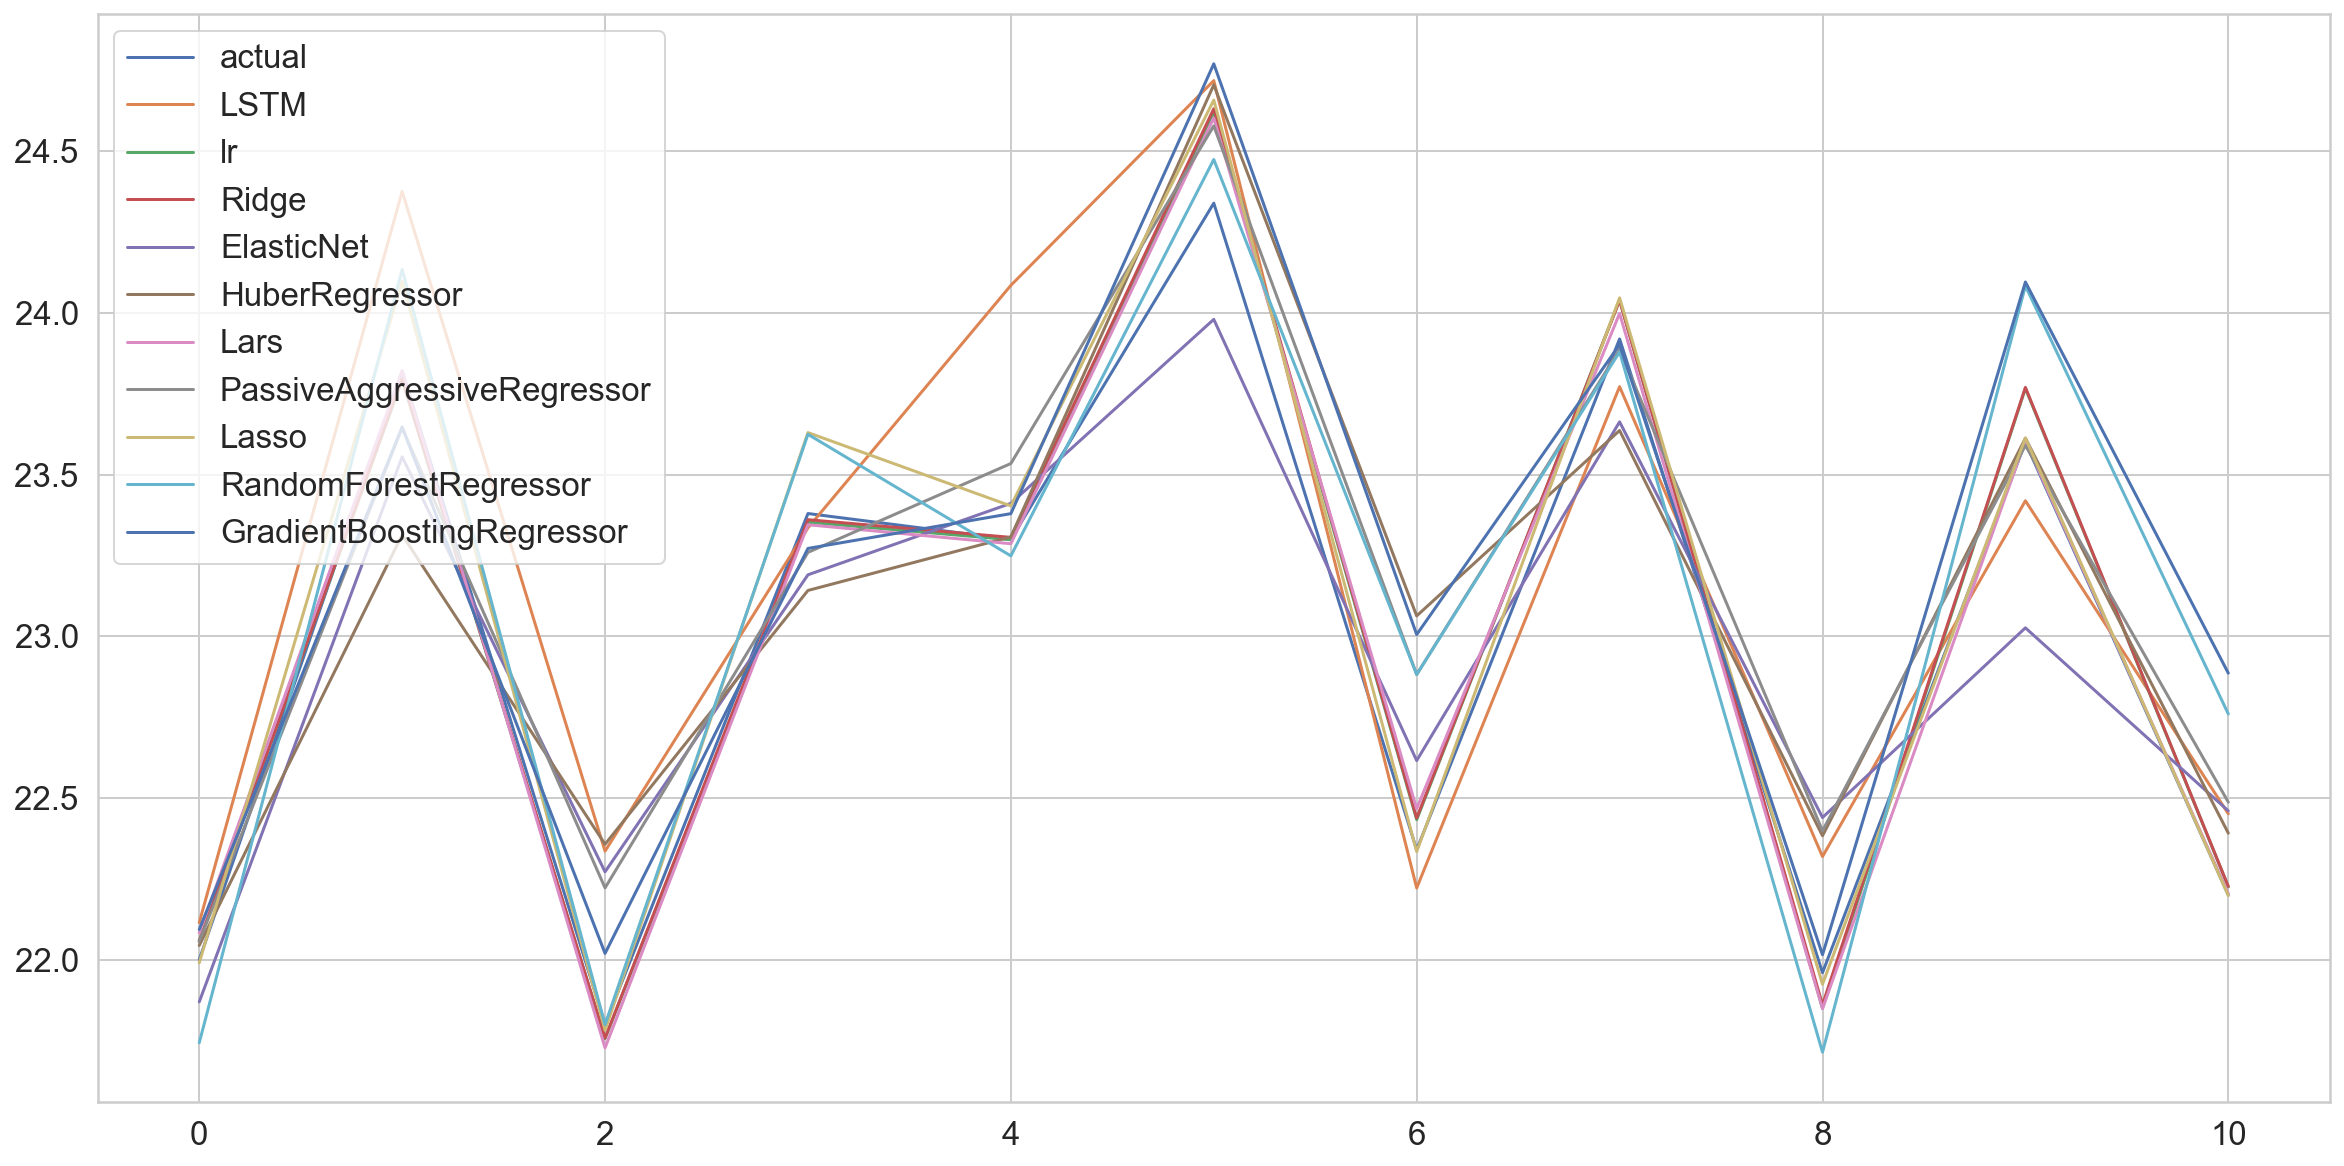

In [113]:
fig = plt.subplots( figsize=(20,10))
plt.plot(y_valid[:-1], label = "actual")
plt.plot(LSTM_valid_pred, label = "LSTM")
plt.plot(Lr_valid_pred, label = "lr")
plt.plot(Ridge_valid_pred, label = "Ridge")
plt.plot(ElasticNet_valid_pred, label = "ElasticNet")
plt.plot(HuberRegressor_valid_pred, label = "HuberRegressor")
plt.plot(Lars_valid_pred, label = "Lars")
# plt.plot(LassoLars_valid_pred, label = "LassoLars")
plt.plot(PassiveAggressiveRegressor_valid_pred, label = "PassiveAggressiveRegressor")
#plt.plot(RANSACRegressor_valid_pred, label = "RANSACRegressor")
# plt.plot(SGDRegressor_valid_pred, label = "SGDRegressor")
plt.plot(Lasso_valid_pred, label = "Lasso")
plt.plot(RandomForestRegressor_valid_pred, label = "RandomForestRegressor")
plt.plot(GradientBoostingRegressor_valid_pred, label = "GradientBoostingRegressor")
plt.legend(loc=2)
plt.show()

In [114]:
R2_score_valid_LSTM = r2_score(y_valid[:-1],nn_model.predict(X_valid))

In [115]:
R2_traininig_score_LSTM = r2_score(LSTM_training_outputs,nn_model.predict(LSTM_training_inputs))

In [116]:
R2_score_test_LSTM=r2_score(LSTM_test_outputs,nn_model.predict(LSTM_test_inputs))

In [117]:
R2_score_test_LSTM

0.9654030627262129

In [118]:
R2_traininig_score_LSTM

0.9948597022126398

In [119]:
R2_score_valid_LSTM

0.8077947238646308

In [120]:
models = ['LSTM','LR', 'lasso', 'ridge', 'en', 'huber', 'lars', 'pa', #'ranscac',
          'gboost', 'rt']
Training_R2=[R2_traininig_score_LSTM,lr.score(X_train,LSTM_training_outputs),
            lasso.score(X_train,LSTM_training_outputs),ridge.score(X_train,LSTM_training_outputs), 
            en.score(X_train,LSTM_training_outputs),huber.score(X_train,LSTM_training_outputs),
            lars.score(X_train,LSTM_training_outputs),
            pa.score(X_train,LSTM_training_outputs), #ranscac.score(X_train,LSTM_training_outputs),
             gboost.score(X_train,LSTM_training_outputs), rt.score(X_train,LSTM_training_outputs)]
Test_R2=[R2_score_test_LSTM,lr.score(X_test,LSTM_test_outputs),lasso.score(X_test,LSTM_test_outputs), 
         ridge.score(X_test,LSTM_test_outputs),en.score(X_test,LSTM_test_outputs), 
         huber.score(X_test,LSTM_test_outputs),lars.score(X_test,LSTM_test_outputs), 
         pa.score(X_test,LSTM_test_outputs), 
        # ranscac.score(X_test,LSTM_test_outputs), 
         gboost.score(X_test,LSTM_test_outputs),rt.score(X_test,LSTM_test_outputs)]
valid_R2=[R2_score_valid_LSTM,lr.score(X_valid_resaped, y_valid[:-1]),lasso.score(X_valid_resaped, y_valid[:-1]), 
         ridge.score(X_valid_resaped, y_valid[:-1]),en.score(X_valid_resaped, y_valid[:-1]), 
         huber.score(X_valid_resaped, y_valid[:-1]),lars.score(X_valid_resaped, y_valid[:-1]), 
         pa.score(X_valid_resaped, y_valid[:-1]), 
         #ranscac.score(X_valid_resaped, y_valid[:-1]), 
         gboost.score(X_valid_resaped, y_valid[:-1]),rt.score(X_valid_resaped, y_valid[:-1])]

In [121]:
R2_scores = pd.DataFrame({'models' : models,
                                'Training_R2' : Training_R2,
                                'Test_R2' :Test_R2  ,
                                'valid_R2':valid_R2 ,
                                }, 
                                columns=[ 'models','Training_R2','Test_R2','valid_R2'])

In [122]:
R2_scores

,models,Training_R2,Test_R2,valid_R2
0,LSTM,0.994860,0.965403,0.807795
1,LR,0.995440,0.968120,0.982340
2,lasso,0.994661,0.957917,0.968103
3,ridge,0.995440,0.968115,0.981796
4,en,0.994309,0.950265,0.852146
5,huber,0.995042,0.966308,0.814223
6,lars,0.995428,0.967002,0.986160
7,pa,0.995097,0.965389,0.893041
8,gboost,0.998874,0.963847,0.828863
9,rt,0.999272,0.959420,0.864650


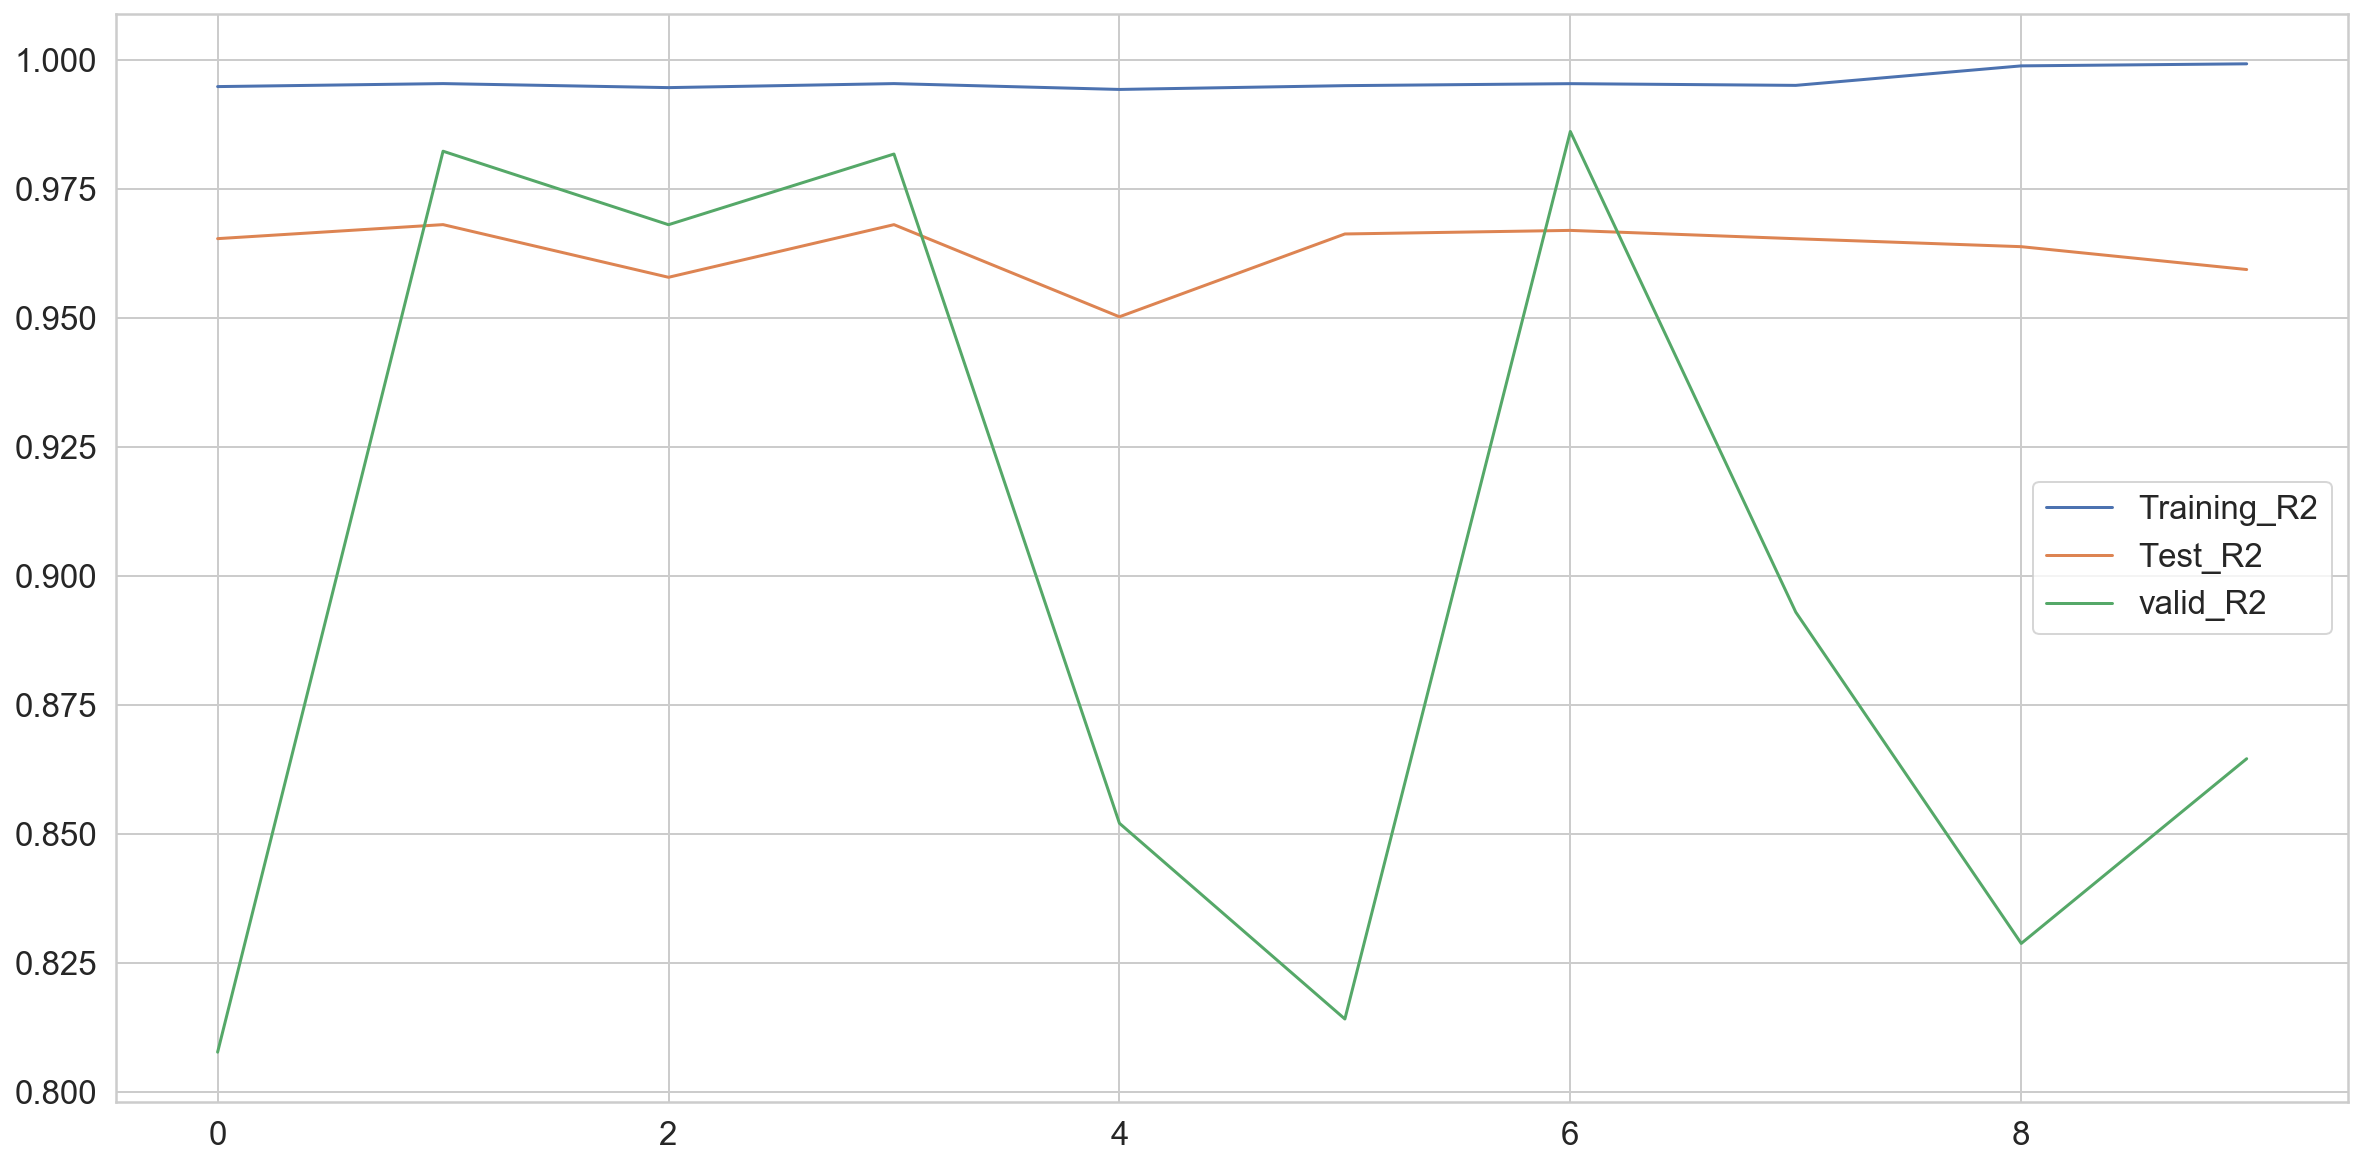

In [131]:
fig = plt.subplots( figsize=(20,10))
plt.plot(R2_scores['Training_R2'] ,label = "Training_R2")
plt.plot(R2_scores['Test_R2'] ,label = "Test_R2")
plt.plot(R2_scores['valid_R2'] ,label = "valid_R2")
xlabel=R2_scores['models']
plt.legend()
plt.show()